# Predicting Municipal Sustainable Development Index (IMDS) Using Satellite Embeddings

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/ds4bolivia/blob/master/notebooks/predict_imds_rf.ipynb)

## Overview

This notebook demonstrates how to predict the **IMDS (Índice Municipal de Desarrollo Sostenible)** - a composite index that aggregates all Sustainable Development Goal (SDG) indicators into a single municipal development score - using 64-dimensional satellite imagery embeddings from Google Earth Engine.

### Learning Objectives

By the end of this notebook, you will be able to:

1. Load and merge multiple datasets for machine learning
2. Prepare features and target variables for regression
3. Train a Random Forest model with cross-validation
4. Evaluate model performance using appropriate metrics
5. Analyze feature importance from satellite embeddings
6. Interpret prediction errors and identify patterns

### About the IMDS

The IMDS provides a comprehensive measure of sustainable development at the municipal level in Bolivia. It combines indicators across all 17 SDGs into a single normalized score (0-100), making it valuable for:

- Comparing overall development across municipalities
- Tracking progress toward sustainable development
- Identifying areas requiring targeted interventions

### Research Question

**Can satellite imagery features predict overall municipal sustainable development in Bolivia?**

---

## 1. Setup and Libraries

First, we import all necessary libraries for data manipulation, machine learning, and visualization.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Data Loading

We load three datasets from the DS4Bolivia repository:

1. **SDG Data**: Contains the IMDS (our target variable) and other SDG indices
2. **Satellite Embeddings**: 64-dimensional feature vectors derived from Google Earth Engine
3. **Region Names**: Municipality and department names for interpretation

In [2]:
# Define data URLs from the DS4Bolivia repository
REPO_URL = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master"

url_sdg = f"{REPO_URL}/sdg/sdg.csv"
url_emb = f"{REPO_URL}/satelliteEmbeddings/satelliteEmbeddings2017.csv"
url_names = f"{REPO_URL}/regionNames/regionNames.csv"

# Load datasets
print("Loading datasets...")
df_sdg = pd.read_csv(url_sdg)
df_embeddings = pd.read_csv(url_emb)
df_names = pd.read_csv(url_names)

print(f"SDG data loaded: {len(df_sdg)} municipalities")
print(f"Satellite embeddings loaded: {len(df_embeddings)} municipalities")
print(f"Region names loaded: {len(df_names)} municipalities")

Loading datasets...
SDG data loaded: 339 municipalities
Satellite embeddings loaded: 339 municipalities
Region names loaded: 339 municipalities


### 2.1 Explore the SDG Data

Let's examine the structure of our SDG dataset and understand the IMDS variable.

In [3]:
# Display SDG dataset structure
print("SDG Dataset Columns:")
print(df_sdg.columns.tolist())
print(f"\nShape: {df_sdg.shape}")

SDG Dataset Columns:
['asdf_id', 'imds', 'index_sdg1', 'index_sdg2', 'index_sdg3', 'index_sdg4', 'index_sdg5', 'index_sdg6', 'index_sdg7', 'index_sdg8', 'index_sdg9', 'index_sdg10', 'index_sdg11', 'index_sdg13', 'index_sdg15', 'index_sdg16', 'index_sdg17']

Shape: (339, 17)


In [4]:
# Examine the IMDS variable
print("IMDS (Municipal Sustainable Development Index) Statistics:")
print(df_sdg['imds'].describe())

IMDS (Municipal Sustainable Development Index) Statistics:
count    339.000000
mean      51.050442
std        6.771824
min       35.700001
25%       47.000000
50%       50.500000
75%       54.850001
max       80.199997
Name: imds, dtype: float64


### 2.2 Explore the Satellite Embeddings

The satellite embeddings are 64-dimensional vectors (A00 to A63) derived from satellite imagery using deep learning models in Google Earth Engine.

In [5]:
# Display embedding structure
print("Satellite Embeddings Columns:")
print(df_embeddings.columns.tolist())
print(f"\nShape: {df_embeddings.shape}")
print(f"\nFirst few rows:")
df_embeddings.head()

Satellite Embeddings Columns:
['asdf_id', 'A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63']

Shape: (339, 65)

First few rows:


,asdf_id,A00,A01,A02,A03,A04,A05,A06,A07,A08,...,A54,A55,A56,A57,A58,A59,A60,A61,A62,A63
0,0,-0.060433,-0.052295,-0.009320,0.052057,-0.128304,0.090421,-0.001657,-0.058989,-0.106733,...,0.248148,-0.045881,-0.055636,-0.092110,-0.094513,0.049138,0.113624,0.069979,-0.263989,-0.210946
1,1,-0.104140,0.013027,-0.063797,-0.013892,-0.181658,0.135043,0.049367,-0.071159,-0.058262,...,0.205657,-0.037264,-0.110212,-0.099416,-0.106212,0.033791,0.107212,0.094207,-0.244334,-0.253715
2,2,-0.107063,0.021826,-0.036949,0.017480,-0.132527,0.134873,0.048462,-0.040046,-0.095563,...,0.194616,-0.054786,-0.095147,-0.083520,-0.105023,0.046669,0.116487,0.110073,-0.213107,-0.238494
3,3,-0.130482,-0.044621,-0.114217,-0.050099,-0.177919,0.117084,0.046248,-0.081321,-0.023262,...,0.197577,-0.022868,-0.121438,-0.150997,-0.126823,-0.003014,0.079527,0.093427,-0.212337,-0.289366
4,4,-0.123298,-0.058626,-0.108308,-0.053840,-0.178878,0.136014,0.042356,-0.101911,-0.003154,...,0.187296,-0.033201,-0.118475,-0.147779,-0.143258,0.006860,0.090282,0.098707,-0.218027,-0.287523


## 3. Data Preparation

We merge our datasets using `asdf_id` as the common identifier and prepare our features (X) and target variable (y).

In [6]:
# Merge datasets
# Step 1: Merge SDG data (with IMDS) with satellite embeddings
df_merged = df_sdg[['asdf_id', 'imds']].merge(
    df_embeddings,
    on='asdf_id',
    how='inner'
)

# Step 2: Add region names for interpretation
df_merged = df_merged.merge(
    df_names[['asdf_id', 'mun', 'dep']],
    on='asdf_id',
    how='left'
)

print(f"Merged dataset shape: {df_merged.shape}")
print(f"Columns: {df_merged.columns.tolist()}")

Merged dataset shape: (339, 68)
Columns: ['asdf_id', 'imds', 'A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'mun', 'dep']


In [7]:
# Check for missing values in IMDS
missing_imds = df_merged['imds'].isna().sum()
print(f"Missing IMDS values: {missing_imds}")

# Remove rows with missing IMDS (if any)
df_clean = df_merged.dropna(subset=['imds']).copy()
print(f"Valid municipalities for analysis: {len(df_clean)}")

Missing IMDS values: 0
Valid municipalities for analysis: 339


In [8]:
# Prepare features (X) and target (y)
# Features are the 64 satellite embedding dimensions (A00 to A63)
embedding_cols = [f'A{str(i).zfill(2)}' for i in range(64)]

X = df_clean[embedding_cols].values
y = df_clean['imds'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nIMDS range: [{y.min():.2f}, {y.max():.2f}]")
print(f"IMDS mean: {y.mean():.2f} ± {y.std():.2f}")

Feature matrix shape: (339, 64)
Target variable shape: (339,)

IMDS range: [35.70, 80.20]
IMDS mean: 51.05 ± 6.76


### 3.1 Visualize IMDS Distribution

Let's understand the distribution of our target variable.

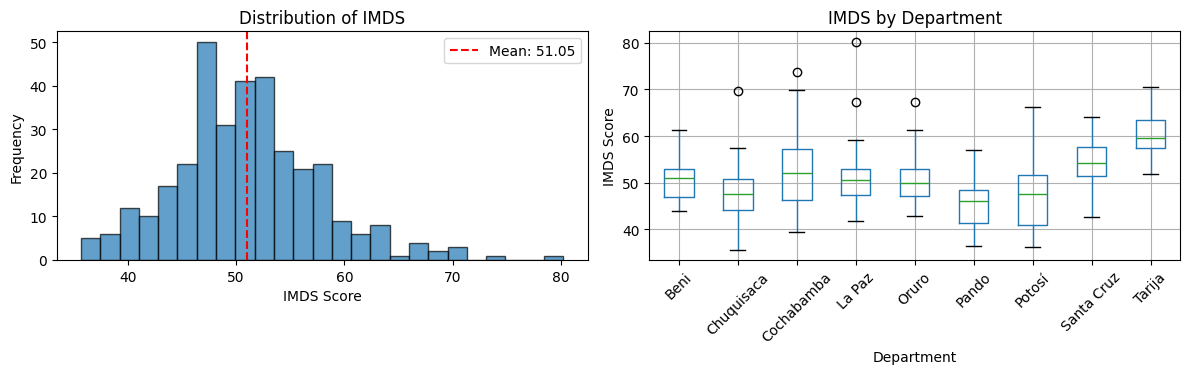

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(y, bins=25, edgecolor='black', alpha=0.7)
axes[0].axvline(x=y.mean(), color='red', linestyle='--', label=f'Mean: {y.mean():.2f}')
axes[0].set_xlabel('IMDS Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of IMDS')
axes[0].legend()

# Box plot by department
df_clean.boxplot(column='imds', by='dep', ax=axes[1], rot=45)
axes[1].set_xlabel('Department')
axes[1].set_ylabel('IMDS Score')
axes[1].set_title('IMDS by Department')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

## 4. Train-Test Split

We split our data into training (80%) and test (20%) sets. The test set will be used for final model evaluation.

In [10]:
# Split data into training and test sets
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df_clean.index,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print(f"Training set: {len(X_train)} municipalities ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} municipalities ({len(X_test)/len(X)*100:.1f}%)")

Training set: 271 municipalities (79.9%)
Test set: 68 municipalities (20.1%)


## 5. Model Configuration

We use a **Random Forest Regressor** for this prediction task. Random Forests are well-suited for:

- High-dimensional data (64 features)
- Capturing non-linear relationships
- Providing feature importance rankings
- Handling potential interactions between features

### Hyperparameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| n_estimators | 100 | Number of trees in the forest |
| max_depth | 20 | Maximum depth of each tree |
| min_samples_split | 5 | Minimum samples to split a node |
| min_samples_leaf | 2 | Minimum samples at leaf nodes |
| max_features | sqrt | Features considered per split (~8) |

In [11]:
# Configure Random Forest model
model_params = {
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': RANDOM_STATE,
    'n_jobs': -1  # Use all available cores
}

# Initialize the model
rf_model = RandomForestRegressor(**model_params)

print("Random Forest model configured with:")
for param, value in model_params.items():
    if param not in ['random_state', 'n_jobs']:
        print(f"  - {param}: {value}")

Random Forest model configured with:
  - n_estimators: 100
  - max_depth: 20
  - min_samples_split: 5
  - min_samples_leaf: 2
  - max_features: sqrt


## 6. Cross-Validation

Before training our final model, we perform **5-fold cross-validation** to get a reliable estimate of model performance. This technique:

1. Splits the training data into 5 equal parts (folds)
2. Trains on 4 folds and validates on the remaining fold
3. Repeats 5 times, using each fold as validation once
4. Provides mean and standard deviation of performance

In [12]:
# Setup cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Perform cross-validation
print("Performing 5-fold cross-validation...")
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='r2')

print("\nCross-validation results:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: R² = {score:.4f}")

print(f"\nMean CV R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

Performing 5-fold cross-validation...

Cross-validation results:
  Fold 1: R² = 0.2058
  Fold 2: R² = 0.2022
  Fold 3: R² = 0.2511
  Fold 4: R² = 0.2097
  Fold 5: R² = 0.2754

Mean CV R²: 0.2288 (±0.0292)


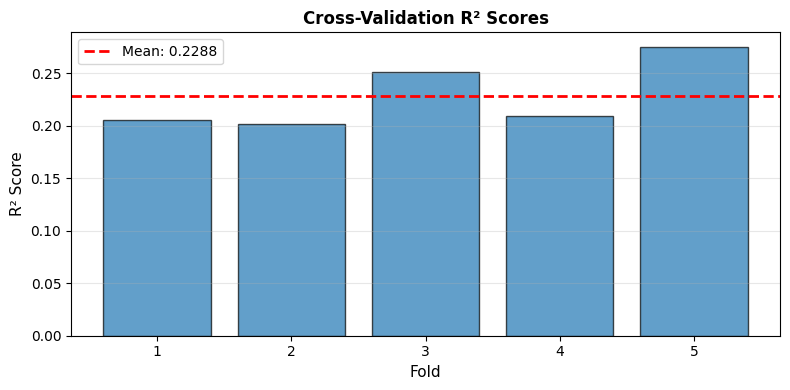

In [13]:
# Visualize cross-validation scores
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(cv_scores)+1), cv_scores, edgecolor='black', alpha=0.7)
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', lw=2,
            label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold', fontsize=11)
plt.ylabel('R² Score', fontsize=11)
plt.title('Cross-Validation R² Scores', fontsize=12, fontweight='bold')
plt.xticks(range(1, len(cv_scores)+1))
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 7. Model Training and Evaluation

Now we train the model on the full training set and evaluate it on the held-out test set.

In [14]:
# Train the model on the full training set
print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("Training complete!")

Training Random Forest model...
Training complete!


In [15]:
# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate metrics
# Training set
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

# Test set
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("=" * 50)
print("MODEL PERFORMANCE METRICS")
print("=" * 50)
print(f"\nTraining Set ({len(X_train)} municipalities):")
print(f"  R² Score:  {train_r2:.4f}")
print(f"  RMSE:      {train_rmse:.4f} IMDS points")
print(f"  MAE:       {train_mae:.4f} IMDS points")

print(f"\nTest Set ({len(X_test)} municipalities):")
print(f"  R² Score:  {test_r2:.4f}")
print(f"  RMSE:      {test_rmse:.4f} IMDS points")
print(f"  MAE:       {test_mae:.4f} IMDS points")
print("=" * 50)

MODEL PERFORMANCE METRICS

Training Set (271 municipalities):
  R² Score:  0.8160
  RMSE:      2.8215 IMDS points
  MAE:       2.0247 IMDS points

Test Set (68 municipalities):
  R² Score:  0.2284
  RMSE:      6.5286 IMDS points
  MAE:       4.7516 IMDS points


### 7.1 Understanding the Metrics

| Metric | Description | Interpretation |
|--------|-------------|----------------|
| **R²** | Proportion of variance explained | 0.23 means 23% of IMDS variance is explained by satellite features |
| **RMSE** | Root Mean Squared Error | Average prediction error (penalizes large errors more) |
| **MAE** | Mean Absolute Error | Average absolute prediction error in IMDS points |

**Note**: The gap between training R² (~0.82) and test R² (~0.23) indicates some overfitting, which is common with Random Forests on small datasets.

### 7.2 Visualize Predictions

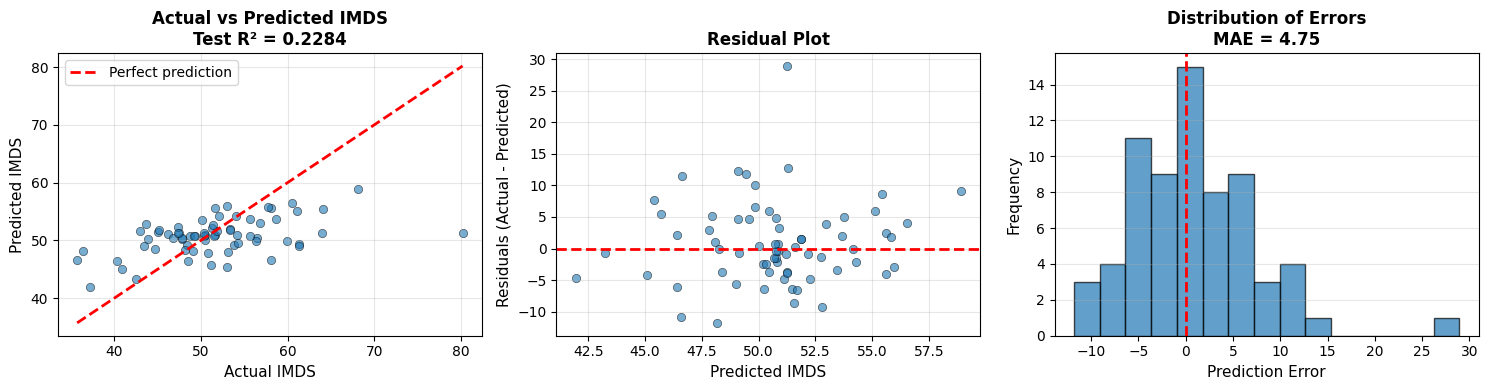

In [16]:
# Calculate prediction errors
test_errors = y_test - y_test_pred

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual IMDS', fontsize=11)
axes[0].set_ylabel('Predicted IMDS', fontsize=11)
axes[0].set_title(f'Actual vs Predicted IMDS\nTest R² = {test_r2:.4f}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Residual plot
axes[1].scatter(y_test_pred, test_errors, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted IMDS', fontsize=11)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=11)
axes[1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# 3. Error distribution
axes[2].hist(test_errors, bins=15, edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Prediction Error', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].set_title(f'Distribution of Errors\nMAE = {test_mae:.2f}', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

Random Forests provide built-in feature importance scores based on how much each feature contributes to reducing prediction error across all trees.

In [17]:
# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': embedding_cols,
    'importance': importances,
    'rank': np.argsort(np.argsort(importances)[::-1]) + 1
}).sort_values('importance', ascending=False)

# Display top 20 features
print("TOP 20 MOST IMPORTANT FEATURES:")
print("=" * 50)
cumulative = 0
for i in range(20):
    idx = indices[i]
    cumulative += importances[idx]
    print(f"{i+1:2d}. {embedding_cols[idx]}: {importances[idx]:.4f} (Cumulative: {cumulative*100:.1f}%)")

TOP 20 MOST IMPORTANT FEATURES:
 1. A30: 0.0619 (Cumulative: 6.2%)
 2. A59: 0.0380 (Cumulative: 10.0%)
 3. A57: 0.0303 (Cumulative: 13.0%)
 4. A13: 0.0276 (Cumulative: 15.8%)
 5. A26: 0.0249 (Cumulative: 18.3%)
 6. A20: 0.0245 (Cumulative: 20.7%)
 7. A21: 0.0239 (Cumulative: 23.1%)
 8. A58: 0.0219 (Cumulative: 25.3%)
 9. A33: 0.0216 (Cumulative: 27.5%)
10. A00: 0.0215 (Cumulative: 29.6%)
11. A04: 0.0213 (Cumulative: 31.7%)
12. A50: 0.0211 (Cumulative: 33.8%)
13. A24: 0.0197 (Cumulative: 35.8%)
14. A41: 0.0187 (Cumulative: 37.7%)
15. A25: 0.0182 (Cumulative: 39.5%)
16. A32: 0.0177 (Cumulative: 41.3%)
17. A43: 0.0175 (Cumulative: 43.0%)
18. A47: 0.0172 (Cumulative: 44.7%)
19. A63: 0.0171 (Cumulative: 46.5%)
20. A53: 0.0165 (Cumulative: 48.1%)


In [18]:
# Calculate cumulative importance
cumsum = np.cumsum(importances[indices])
n_features_80 = np.argmax(cumsum >= 0.80) + 1

print(f"\nFeatures needed for 80% importance: {n_features_80}/64 ({n_features_80/64*100:.1f}%)")


Features needed for 80% importance: 44/64 (68.8%)


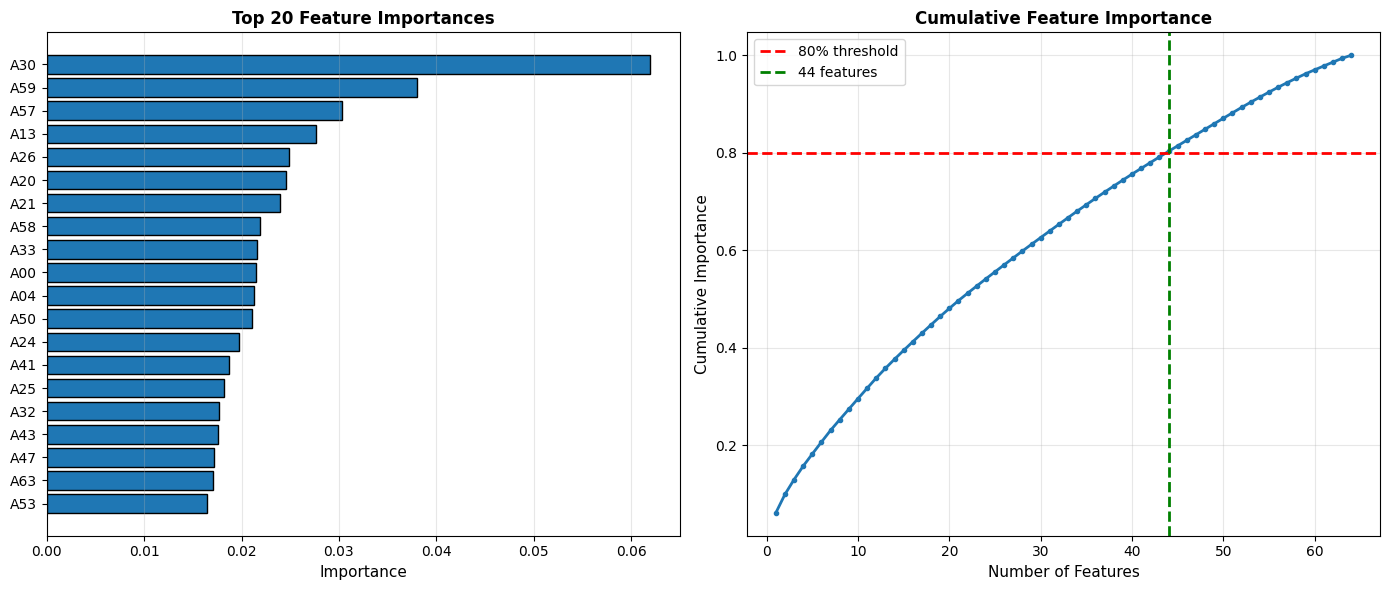

In [19]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Top 20 feature importances
top_n = 20
top_indices = indices[:top_n]
top_features = [embedding_cols[i] for i in top_indices]
top_importances = importances[top_indices]

axes[0].barh(range(top_n), top_importances, edgecolor='black')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_features)
axes[0].set_xlabel('Importance', fontsize=11)
axes[0].set_title('Top 20 Feature Importances', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# 2. Cumulative importance
axes[1].plot(range(1, 65), cumsum, linewidth=2, marker='o', markersize=3)
axes[1].axhline(y=0.8, color='r', linestyle='--', lw=2, label='80% threshold')
axes[1].axvline(x=n_features_80, color='g', linestyle='--', lw=2, label=f'{n_features_80} features')
axes[1].set_xlabel('Number of Features', fontsize=11)
axes[1].set_ylabel('Cumulative Importance', fontsize=11)
axes[1].set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Key Insight: Distributed Feature Importance

Unlike more specific indicators (e.g., extreme energy poverty), the IMDS requires many features to capture its variance. This makes sense because IMDS is a composite index combining diverse dimensions of development that manifest in different ways in satellite imagery.

## 9. Prediction Error Analysis

Understanding where the model makes large errors helps us identify patterns and limitations of satellite-based predictions.

In [20]:
# Create results dataframe for test set
test_results = df_clean.iloc[idx_test].copy()
test_results['imds_actual'] = y_test
test_results['imds_predicted'] = y_test_pred
test_results['error'] = test_errors
test_results['abs_error'] = np.abs(test_errors)

print(f"Test results dataframe created with {len(test_results)} municipalities")

Test results dataframe created with 68 municipalities


### 9.1 Overpredicted Municipalities

These are municipalities where the model predicts **higher** development than the actual IMDS. The satellite features suggest more development than actually exists.

In [21]:
# Top 10 overpredicted (model predicts higher than actual)
overpredicted = test_results.nsmallest(10, 'error')

print("TOP 10 OVERPREDICTED MUNICIPALITIES")
print("(Model predicts higher development than actual)")
print("=" * 70)

for _, row in overpredicted.iterrows():
    print(f"\n{row['mun']}, {row['dep']}")
    print(f"  Actual: {row['imds_actual']:.2f} | Predicted: {row['imds_predicted']:.2f} | Error: {row['error']:.2f}")

TOP 10 OVERPREDICTED MUNICIPALITIES
(Model predicts higher development than actual)

Tinguipaya, Potosí
  Actual: 36.40 | Predicted: 48.19 | Error: -11.79

Poroma, Chuquisaca
  Actual: 35.70 | Predicted: 46.58 | Error: -10.88

Ayata, La Paz
  Actual: 43.60 | Predicted: 52.81 | Error: -9.21

El Choro, Oruro
  Actual: 42.90 | Predicted: 51.57 | Error: -8.67

Cruz de Machacamarca, Oruro
  Actual: 45.20 | Predicted: 51.71 | Error: -6.51

Puerto Pérez, La Paz
  Actual: 45.00 | Predicted: 51.49 | Error: -6.49

Loreto, Beni
  Actual: 43.90 | Predicted: 50.26 | Error: -6.36

Colquechaca, Potosí
  Actual: 40.30 | Predicted: 46.39 | Error: -6.09

Aucapata, La Paz
  Actual: 43.40 | Predicted: 49.02 | Error: -5.62

Calacoto, La Paz
  Actual: 46.20 | Predicted: 51.10 | Error: -4.90


### 9.2 Underpredicted Municipalities

These are municipalities where the model predicts **lower** development than the actual IMDS. These areas achieve better development outcomes than their satellite features suggest.

In [22]:
# Top 10 underpredicted (model predicts lower than actual)
underpredicted = test_results.nlargest(10, 'error')

print("TOP 10 UNDERPREDICTED MUNICIPALITIES")
print("(Model predicts lower development than actual)")
print("=" * 70)

for _, row in underpredicted.iterrows():
    print(f"\n{row['mun']}, {row['dep']}")
    print(f"  Actual: {row['imds_actual']:.2f} | Predicted: {row['imds_predicted']:.2f} | Error: {row['error']:.2f}")

TOP 10 UNDERPREDICTED MUNICIPALITIES
(Model predicts lower development than actual)

La Paz, La Paz
  Actual: 80.20 | Predicted: 51.26 | Error: 28.94

Vinto, Cochabamba
  Actual: 64.00 | Predicted: 51.31 | Error: 12.69

Trinidad, Beni
  Actual: 61.30 | Predicted: 49.07 | Error: 12.23

Huachacalla, Oruro
  Actual: 61.30 | Predicted: 49.44 | Error: 11.86

Llallagua, Potosí
  Actual: 58.10 | Predicted: 46.64 | Error: 11.46

Tupiza, Potosí
  Actual: 59.90 | Predicted: 49.84 | Error: 10.06

Colcapirhua, Cochabamba
  Actual: 68.10 | Predicted: 58.92 | Error: 9.18

Santa Cruz de la Sierra, Santa Cruz
  Actual: 64.10 | Predicted: 55.43 | Error: 8.67

Camargo, Chuquisaca
  Actual: 53.00 | Predicted: 45.38 | Error: 7.62

Uyuni, Potosí
  Actual: 56.40 | Predicted: 49.83 | Error: 6.57


### 9.3 Error Patterns by Department

In [23]:
# Analyze errors by department
dept_errors = test_results.groupby('dep').agg({
    'error': ['mean', 'std', 'count'],
    'abs_error': 'mean'
}).round(2)

dept_errors.columns = ['Mean Error', 'Std Error', 'Count', 'Mean Abs Error']
dept_errors = dept_errors.sort_values('Mean Error')

print("PREDICTION ERRORS BY DEPARTMENT:")
print("=" * 60)
print(dept_errors.to_string())

PREDICTION ERRORS BY DEPARTMENT:
            Mean Error  Std Error  Count  Mean Abs Error
dep                                                     
Chuquisaca       -1.29       8.22      4            6.59
Pando            -1.04       4.44      2            3.14
Oruro            -0.75       6.07      8            3.91
La Paz           -0.05       7.92     19            4.58
Santa Cruz        0.71       4.09     10            3.08
Potosí            1.46       6.84     13            5.85
Tarija            3.34       1.99      2            3.34
Beni              3.52       9.35      3            7.76
Cochabamba        3.87       5.58      7            5.04


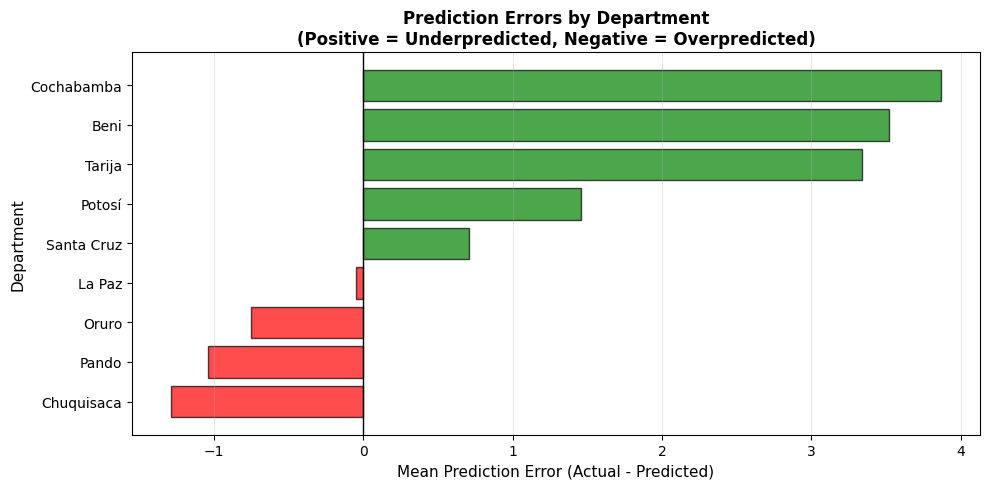

In [24]:
# Visualize errors by department
plt.figure(figsize=(10, 5))

dept_order = dept_errors.sort_values('Mean Error').index
colors = ['green' if x > 0 else 'red' for x in dept_errors.loc[dept_order, 'Mean Error']]

plt.barh(dept_order, dept_errors.loc[dept_order, 'Mean Error'], color=colors, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='black', linestyle='-', lw=1)
plt.xlabel('Mean Prediction Error (Actual - Predicted)', fontsize=11)
plt.ylabel('Department', fontsize=11)
plt.title('Prediction Errors by Department\n(Positive = Underpredicted, Negative = Overpredicted)',
          fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 10. Summary and Conclusions

### Model Performance Summary

In [25]:
# Create summary table
summary = pd.DataFrame({
    'Metric': ['Model', 'Target Variable', 'Number of Features', 'Training Samples', 'Test Samples',
               'CV Mean R²', 'CV Std R²', 'Test R²', 'Test RMSE', 'Test MAE', 'Features for 80% Importance'],
    'Value': ['Random Forest Regressor', 'IMDS (Municipal Sustainable Development Index)', 64,
              len(X_train), len(X_test), f"{cv_scores.mean():.4f}", f"{cv_scores.std():.4f}",
              f"{test_r2:.4f}", f"{test_rmse:.4f}", f"{test_mae:.4f}", n_features_80]
})

print("MODEL SUMMARY")
print("=" * 60)
for _, row in summary.iterrows():
    print(f"{row['Metric']:40s} {row['Value']}")

MODEL SUMMARY
Model                                    Random Forest Regressor
Target Variable                          IMDS (Municipal Sustainable Development Index)
Number of Features                       64
Training Samples                         271
Test Samples                             68
CV Mean R²                               0.2288
CV Std R²                                0.0292
Test R²                                  0.2284
Test RMSE                                6.5286
Test MAE                                 4.7516
Features for 80% Importance              44


### Key Findings

1. **Moderate Predictive Power (R² ≈ 23%)**: Satellite embeddings explain about 23% of the variance in IMDS. This is expected because IMDS is a composite index including many dimensions not directly observable from satellite imagery.

2. **Urban Centers Systematically Underpredicted**: Cities like La Paz achieve higher development than satellite features suggest. This indicates that institutional services, economic opportunities, and other non-physical development dimensions are concentrated in urban areas.

3. **Rural Areas Often Overpredicted**: Some rural municipalities show visible infrastructure in satellite imagery that doesn't translate to actual development outcomes. Factors like isolation, climate, and service access are not captured.

4. **Distributed Feature Importance**: Unlike specific indicators, overall development requires many satellite features (44/64 for 80% importance). This reflects the multi-dimensional nature of the IMDS.

### Limitations

- **Invisible Dimensions**: Many SDG components (governance, education quality, health services, gender equality) are not directly observable from satellite imagery
- **Composite Index Complexity**: Aggregating diverse indicators into a single score creates challenges for prediction
- **Sample Size**: 339 municipalities may limit model complexity

### Practical Applications

1. **Screening Tool**: Use satellite predictions to identify areas for detailed surveys
2. **Monitoring Physical Development**: Track infrastructure changes over time
3. **Complementary Data**: Combine with traditional survey data for comprehensive assessment

---

## References

- **SDG Data Source**: Andersen, L. E., Canelas, S., Gonzales, A., Peñaranda, L. (2020). Atlas municipal de los Objetivos de Desarrollo Sostenible en Bolivia 2020. La Paz: Universidad Privada Boliviana, SDSN Bolivia. https://atlas.sdsnbolivia.org

- **DS4Bolivia Repository**: https://github.com/quarcs-lab/ds4bolivia

- **Satellite Embeddings**: Google Earth Engine aggregated embeddings at municipal level (2017)

---

## Exercises for Students

1. **Compare with Other SDG Indices**: Modify this notebook to predict individual SDG indices (e.g., `index_sdg1`, `index_sdg7`). How does predictive power vary across different SDGs?

2. **Feature Selection**: Try training the model with only the top 20 features. How does performance change?

3. **Alternative Models**: Replace Random Forest with Gradient Boosting (`GradientBoostingRegressor`) or XGBoost. Compare performance.

4. **Spatial Analysis**: Create a map showing prediction errors across municipalities. Are there spatial clusters of over/underprediction?

5. **Hyperparameter Tuning**: Use `GridSearchCV` or `RandomizedSearchCV` to find optimal hyperparameters. Does performance improve significantly?